In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import swifter
from transformers import AutoTokenizer, AutoModelForMaskedLM
import spacy
spacy.cli.download("es_core_news_sm")
nlp = spacy.load("es_core_news_sm")

from tqdm.auto import tqdm
tqdm.pandas()

BARR_BG_PATH = 'data/BARR/BARR_ibereval_background1_set.tsv'
BARR_TRAIN_PATH = 'data/BARR/BARR_ibereval_training2_docs.tsv'

tokenizer = AutoTokenizer.from_pretrained("BSC-TeMU/roberta-base-biomedical-es")

def count_tokens(text, tokenizer=tokenizer):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Return the number of tokens
    return len(tokens)

def count_sentences(text, nlp=nlp):
    return len(list(nlp(text).sents))

def load_barr(path):
    with open(path) as f:
        data = f.readlines()

    data = [x.strip() for x in data]
    data = [x.split('\t') for x in data]

    df = pd.DataFrame(data, columns=["ID", "lang", "text", "abstract"])
    df['text'] = df['text'] + ' ' + df['abstract']
    df = df.drop(columns=['abstract'])

    print("Total Shape:", df.shape)
    print("Spanish Shape:", df[df['lang'] == 'es'].shape)

    return df

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


BARR Background
Total Shape: (112728, 3)
Spanish Shape: (109281, 3)

BARR Train
Total Shape: (526, 3)
Spanish Shape: (478, 3)

Total Shape: (113253, 4)
Spanish Shape: 109759


Pandas Apply: 100%|██████████| 109759/109759 [36:34<00:00, 50.01it/s]


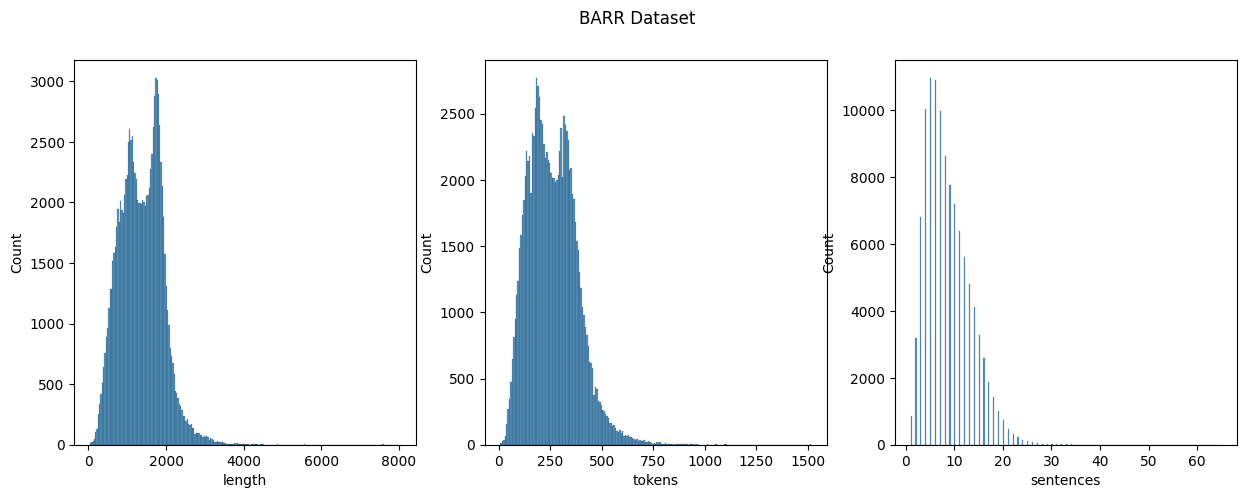

In [15]:
print("BARR Background")
df_bg = load_barr(BARR_BG_PATH)
df_bg["source"] = "BG"

print("\nBARR Train")
df_train = load_barr(BARR_TRAIN_PATH)
df_train.drop(index=0, inplace=True)
df_train["source"] = "TR"

df_total = pd.concat([df_train, df_bg], ignore_index=True)

print("\nTotal Shape:", df_total.shape)
print("Spanish Shape:", df_total[df_total['lang'] == 'es'].shape[0])

df_total = df_total[df_total['lang'] == 'es']

df_total["length"] = df_total["text"].str.len()
df_total["tokens"] = df_total["text"].swifter.apply(count_tokens)
df_total["sentences"] = df_total["text"].swifter.apply(count_sentences)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df_total, x="length", ax=ax[0])
sns.histplot(df_total, x="tokens", ax=ax[1])
sns.histplot(df_total, x="sentences", ax=ax[2])

plt.suptitle("BARR Dataset")
plt.show()

<Axes: xlabel='tokens', ylabel='Count'>

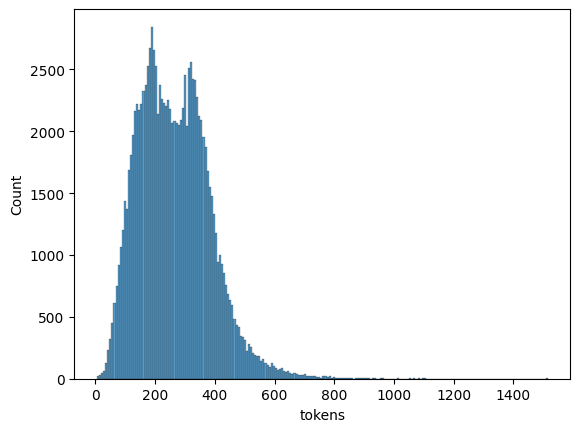

In [6]:
sns.histplot(df_total, x="tokens")

In [16]:
n_tokens = df_total["tokens"].sum()
print(f"Number of tokens: {n_tokens:,}")

n_sentences = df_total["sentences"].sum()
print(f"Number of sentences: {n_sentences:,}")

Number of tokens: 28,793,842
Number of sentences: 944,921


In [19]:
train_sentences = df_total[df_total["source"] == "TR"]["sentences"].sum()
train_tokens = df_total[df_total["source"] == "TR"]["tokens"].sum()
print(f"Number of training sentences: {train_sentences:,}")
print(f"Number of training tokens: {train_tokens:,}")


bg_sentences = df_total[df_total["source"] == "BG"]["sentences"].sum()
bg_tokens = df_total[df_total["source"] == "BG"]["tokens"].sum()
print(f"Number of background sentences: {bg_sentences:,}")
print(f"Number of background tokens: {bg_tokens:,}")

Number of training sentences: 4,150
Number of training tokens: 127,088
Number of background sentences: 940,771
Number of background tokens: 28,666,754
